In [1]:
import os
import time
import math
import random
import logging
import warnings
import operator
import numpy as np
from copy import copy
from typing import Tuple
from functools import reduce, partial

import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torch.optim.adam import Adam
from torchvision import transforms
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid, save_image

import matplotlib
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
from timm.models.vision_transformer import PatchEmbed, Block

from CNNUtils import train, test, valid, output_metric

%matplotlib inline

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


seed_everything()

In [3]:
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.,), (1,))])

mnist_train = torchvision.datasets.MNIST('./data/', train=True, transform=trans, download=True)
mnist_train, mnist_val = random_split(mnist_train, [10000, 50000], generator=torch.Generator().manual_seed(42))

mnist_test = torchvision.datasets.MNIST('./data/', train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=mnist_train, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=mnist_val, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=128, shuffle=True)

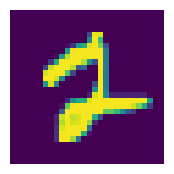

In [4]:
dataiter = iter(train_loader)
sample = next(dataiter)[0][0]
sample = sample.numpy().transpose(1, 2, 0)
plt.figure(figsize=(2, 2))
plt.imshow(sample)
plt.axis('off')
plt.show()

In [5]:
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M, )
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2, )  16

    pos = pos.reshape(-1)  # (M, )  64
    out = np.einsum('m, d -> md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=True):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)  # (H*W, D)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)  # (1+H*W, D)
    return pos_embed

In [6]:
class IT(nn.Module):
    "Multihead Attention Block"
    def __init__(self, dim_Q, dim_K, dim_hidden=64, num_heads=4):
        super(IT, self).__init__()  # Induced Transformer
        self.dim_hidden = dim_hidden
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_hidden)
        self.fc_k = nn.Linear(dim_K, dim_hidden)
        self.fc_v = nn.Linear(dim_K, dim_hidden)
        self.fc_o = nn.Linear(dim_hidden, dim_Q)
        self.ln0 = nn.LayerNorm(dim_Q)
        self.ln1 = nn.LayerNorm(dim_K)
        self.ln2 = nn.LayerNorm(dim_Q)
        self.mlp = nn.Sequential(nn.Linear(dim_Q, 4*dim_Q), nn.GELU(), nn.Linear(4*dim_Q, dim_Q))

    def forward(self, Q, K):
        # LayerNorm
        Q_ = self.ln0(Q)
        # Attention
        Q_, K_, V_ = self.fc_q(Q_), self.fc_k(K), self.fc_v(K)
        dim_head = self.dim_hidden // self.num_heads  # 64 // 4 = 16
        Q_ = torch.cat(Q_.split(dim_head, 2), 0)  # (4*B, K, 16) 
        K_ = torch.cat(K_.split(dim_head, 2), 0)  # (4*B, M, 16) 
        V_ = torch.cat(V_.split(dim_head, 2), 0)  # (4*B, M, 16) 
        A = torch.softmax(Q_.bmm(K_.transpose(1, 2)) / dim_head ** 0.5, 2)  # (4*B, K, M) 
        O = torch.cat(A.bmm(V_).split(Q.size(0), 0), 2)  # (B, K, 64)
        O = self.fc_o(O)
        # Residual
        O = Q + O
        # LayerNorm
        O_ = self.ln2(O)
        # Residual
        O = O + self.mlp(O_)
        return O

In [7]:
class RMAE(nn.Module):
    def __init__(self, img_size=28, patch_size=2, in_chans=1, embed_dim=128, depth=12, num_heads=8, decoder_embed_dim=32, decoder_depth=8, 
                 decoder_num_heads=8, reg_patch_size=4, reg_embed_dim=128):
        super(RMAE, self).__init__()
        self.in_chans = in_chans
        self.patch_size = patch_size
        self.reg_patch_size = reg_patch_size
        # --------------------------------------------------------------------------
        # RMAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) 
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  
        self.blocks = nn.ModuleList([Block(embed_dim, num_heads, qkv_bias=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        # --------------------------------------------------------------------------
        
        # --------------------------------------------------------------------------
        # RMAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False) 
        self.decoder_blocks = nn.ModuleList([Block(decoder_embed_dim, decoder_num_heads, qkv_bias=True) for _ in range(decoder_depth)])
        self.decoder_norm = nn.LayerNorm(decoder_embed_dim)
        self.decoder_pred = nn.Sequential(nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True), nn.Sigmoid()) 
        # --------------------------------------------------------------------------
        
        # --------------------------------------------------------------------------
        # RMAE regularizer specifics
        self.reg_num_patches = ((img_size - reg_patch_size) // reg_patch_size + 1)  ** 2
        self.reg_pos_embed = nn.Parameter(torch.zeros(1, self.reg_num_patches, reg_embed_dim), requires_grad=False)
        self.induce_token = nn.Parameter(torch.zeros(1, 1, reg_embed_dim))
        self.induce_embed = IT(reg_embed_dim, embed_dim)
        self.reg_norm = nn.LayerNorm(reg_embed_dim)
        self.reg_pred = nn.Sequential(nn.Linear(reg_embed_dim, reg_patch_size**2 * in_chans, bias=True), nn.Sigmoid())
        # --------------------------------------------------------------------------
        self.initialize_weights()

    def initialize_weights(self):
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)  
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0)) 

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))  

        reg_pos_embed = get_2d_sincos_pos_embed(self.reg_pos_embed.shape[-1], int(self.reg_num_patches**.5), cls_token=False)
        self.reg_pos_embed.data.copy_(torch.from_numpy(reg_pos_embed).float().unsqueeze(0))
        
        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))  # (embed_dim, in_chans, patch_size, patch_size) 
        
        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        nn.init.normal_(self.cls_token, std=.02)
        nn.init.normal_(self.mask_token, std=.02)
        nn.init.normal_(self.induce_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def random_masking(self, x, mask_ratio):
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]  (N, L)
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # 从小到大排序，返回索引 (N, L)
        ids_restore = torch.argsort(ids_shuffle, dim=1)  # 返回ids_shuffle中，原序列0,1,2,...的索引
        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)  # 原始序列编码所对应的掩模  (N, L)
        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x) 
        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]  
        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)
        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :] 
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)  
        x = torch.cat([cls_tokens, x], dim=1) 
        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)  # (B, 50, 128)
        return x, mask, ids_restore

    def forward_reg(self, x):
        induce_tokens = self.induce_token.repeat(x.shape[0], self.reg_num_patches, 1)  # (B, 49, 128)
        induce_tokens = induce_tokens + self.reg_pos_embed  # (B, 49, 128)
        x = self.induce_embed(induce_tokens, x)  # (B, 49, 128)
        x = self.reg_norm(x)
        x = self.reg_pred(x)  # (B, 49, 16)
        return x
        
    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)  
        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token (N, L+1, 32)
        # add pos embed
        x = x + self.decoder_pos_embed
        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)
        # predictor projection
        x = self.decoder_pred(x)  # (N, L+1, 4*4*3)
        # remove cls token
        x = x[:, 1:, :]
        return x  # (N, L, 4*4*3)

    def patchify(self, imgs, p):
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0
        h = w = imgs.shape[2] // p  # 8
        x = imgs.reshape(shape=(imgs.shape[0], 1, h, p, w, p))
        x = torch.einsum('nchpwq -> nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 1))
        return x

    def unpatchify(self, x, p):
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 1))
        x = torch.einsum('nhwpqc -> nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 1, h * p, h * p))
        return imgs

    def forward_loss(self, imgs, pred, mask, reg_pred):
        target = self.patchify(imgs, self.patch_size)  # (N, L, patch_size**2*1)
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # (N, L), mean loss per patch
        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        reg_target = self.patchify(imgs, self.reg_patch_size)  # (N, L, reg_patch_size**2*1)
        reg_loss = (reg_pred - reg_target) ** 2
        reg_loss = reg_loss.mean()
        return loss + 0.1 * reg_loss
    
    def forward(self, imgs, mask_ratio=0.75):
        # latent: (N, 16, D), maks: (N, L), ids_restore: (N, L) 
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        # pred: (N, L, 4*4*3)
        pred = self.forward_decoder(latent, ids_restore)  # (N, L, p**2*1)
        reg_pred = self.forward_reg(latent)  # (N, 49, 16)
        recons = self.unpatchify(pred, self.patch_size)
        reg_recons = self.unpatchify(reg_pred, self.reg_patch_size)
        loss = self.forward_loss(imgs, pred, mask, reg_pred)
        return loss, recons, mask, reg_recons

In [8]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0
    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


def pretrain(model, train_loader, device):
    model.train()

    optimizer = Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    train_len = len(train_loader)
    path = './model/rmae.pt'
    for epoch in range(200):
        objs = AverageMeter()
        for batch_idx, (image, label) in tqdm(enumerate(train_loader)):
            image = image.to(device)
            optimizer.zero_grad()
            
            return_tuple = model(image)
            loss = return_tuple[0]
            
            loss.backward()
            optimizer.step()

            n = image.shape[0]
            objs.update(loss.data, n)  # 计算所有训练样本的平均损失
            if (batch_idx + 1) == len(train_loader):
                print('epoch: {}, loss: {:.4f}'.format(epoch+1, objs.avg))

        scheduler.step()
    
    torch.save(model.state_dict(), path)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rmae = RMAE()
rmae = rmae.to(device)

In [10]:
def model_summary(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name+':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name+':', num_param)
            total_param += num_param
    print("\nTotal Trainable Parameters:", total_param)

In [11]:
model_summary(rmae)

cls_token: 1x1x128 = 128
mask_token: 1x1x32 = 32
induce_token: 1x1x128 = 128
patch_embed.proj.weight: 128x1x2x2 = 512
patch_embed.proj.bias: 128
blocks.0.norm1.weight: 128
blocks.0.norm1.bias: 128
blocks.0.attn.qkv.weight: 384x128 = 49152
blocks.0.attn.qkv.bias: 384
blocks.0.attn.proj.weight: 128x128 = 16384
blocks.0.attn.proj.bias: 128
blocks.0.norm2.weight: 128
blocks.0.norm2.bias: 128
blocks.0.mlp.fc1.weight: 512x128 = 65536
blocks.0.mlp.fc1.bias: 512
blocks.0.mlp.fc2.weight: 128x512 = 65536
blocks.0.mlp.fc2.bias: 128
blocks.1.norm1.weight: 128
blocks.1.norm1.bias: 128
blocks.1.attn.qkv.weight: 384x128 = 49152
blocks.1.attn.qkv.bias: 384
blocks.1.attn.proj.weight: 128x128 = 16384
blocks.1.attn.proj.bias: 128
blocks.1.norm2.weight: 128
blocks.1.norm2.bias: 128
blocks.1.mlp.fc1.weight: 512x128 = 65536
blocks.1.mlp.fc1.bias: 512
blocks.1.mlp.fc2.weight: 128x512 = 65536
blocks.1.mlp.fc2.bias: 128
blocks.2.norm1.weight: 128
blocks.2.norm1.bias: 128
blocks.2.attn.qkv.weight: 384x128 = 491

In [12]:
path = './model/rmae.pt'

rmae.load_state_dict(torch.load(path))
rmae.eval()
print('done')

done


In [13]:
dataiter = iter(test_loader)
x_test, y_test = next(dataiter)  # 64, 3, 32, 32

x_test_original = x_test[:20]
x_test = x_test_original.numpy().transpose(0, 2, 3, 1)
y_test = y_test[:20].numpy()

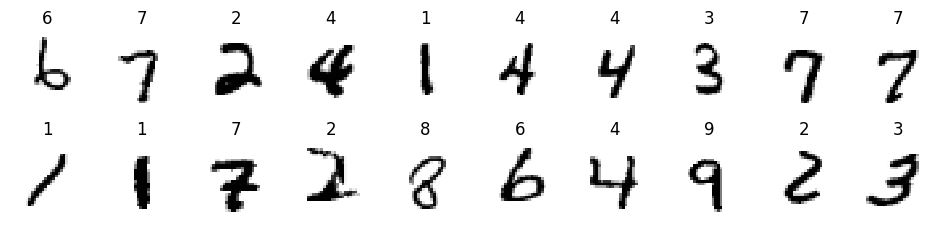

In [14]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

n_rows = 2
n_cols = 10
fig = plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_test[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
fig.savefig('./rmae_originals.pdf', bbox_inches='tight', dpi=300)

In [15]:
return_tuple = rmae(x_test_original.cuda())
recons = return_tuple[1]
recons = recons.detach().cpu().numpy()
recons = recons.transpose(0, 2, 3, 1)

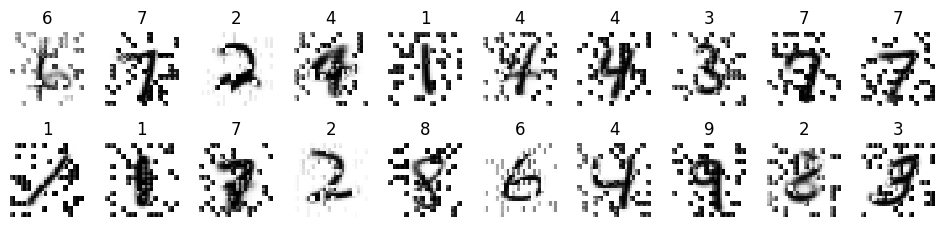

In [16]:
n_rows = 2
n_cols = 10
fig = plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(recons[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
fig.savefig('./rmae_masked_reconstruction.pdf', bbox_inches='tight', dpi=300)

In [17]:
return_tuple = rmae(x_test_original.cuda())
reg_recons = return_tuple[-1]
reg_recons = reg_recons.detach().cpu().numpy()
reg_recons = reg_recons.transpose(0, 2, 3, 1)

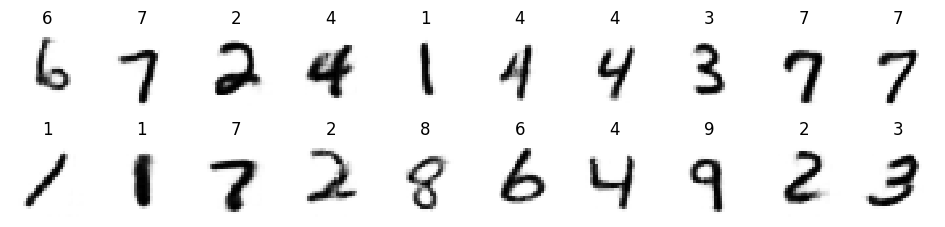

In [18]:
n_rows = 2
n_cols = 10
fig = plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(reg_recons[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
fig.savefig('./rmae_induced_reconstruction.pdf', bbox_inches='tight', dpi=300)

In [31]:
class Encoder(RMAE):
    def forward_encoder(self, x):
        # embed patches
        x = self.patch_embed(x)  # (B, 64, 64)
        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]  # (B, 64, 64)
        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]  # (1, 1, 64)
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)  # (B, 1, 64)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, 64+1, 64)
        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)  # (B, 64+1, 64)
        latent = x[:, 0, :]
        return latent
         
    def forward(self, imgs):
        latent = self.forward_encoder(imgs)
        return latent

In [32]:
encoder = Encoder().cuda()

path = './model/rmae.pt'
encoder.load_state_dict(torch.load(path))
encoder.eval()
print('done')

done


In [33]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))
    
    # We create a scatter plot.
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int_)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i+1), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    fig.savefig('./tsne_rmae.pdf', dpi=300, bbox_inches='tight')

In [34]:
train_codings = []
train_tar = []
for batch_idx, (image, label) in enumerate(train_loader):
    with torch.no_grad():
        image = image.to(device)
        label = label.to(device)
        codings = encoder(image)
    train_codings.append(codings.cpu().data)
    train_tar.append(label.cpu().data)

x_train = torch.concat(train_codings)
y_train = torch.concat(train_tar)

x_train_numpy = x_train.numpy()
y_train_numpy = y_train.numpy()

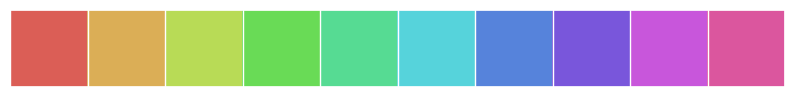

In [35]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

palette = sns.color_palette("hls", 10)
sns.palplot(palette)

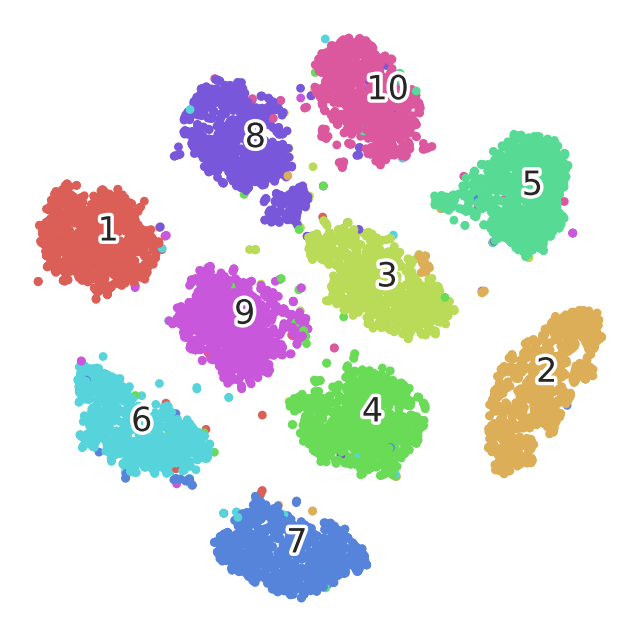

In [36]:
tsne_proj = TSNE(random_state=42).fit_transform(x_train_numpy)

scatter(tsne_proj, y_train_numpy)

## Metrics

In [37]:
def mean_distance(codings, label, c=10):
    codings_per_class = []  # [(16, ) * 10]
    for i in range(c):
        codings_per_class.append(codings[label == i, :])
    centers = [torch.mean(codings_per_class[i], 0) for i in range(c)]
    
    inter_class_distance = torch.tensor(0.)
    for k in range(c - 1):
        for t in range(k + 1, c):
            inter_class_distance += torch.dist(centers[k], centers[t], p=2)
    mean_inter_class_distance = inter_class_distance / (c * (c - 1) / 2)
    
    intra_class_distance = torch.tensor(0.)
    for i in range(c):
        per_intra_class_distance = torch.tensor(0.)
        per_class_features = codings_per_class[i]
        center_feature = centers[i]
        num = per_class_features.size(0)
        for j in range(num):
            per_intra_class_distance += torch.dist(per_class_features[j], center_feature, p=2)
        per_intra_class_distance = per_intra_class_distance / num
        
        intra_class_distance += per_intra_class_distance
    mean_intra_class_distance = intra_class_distance / c
    return mean_intra_class_distance, mean_inter_class_distance

In [38]:
mean_intra_class_distance, mean_inter_class_distance = mean_distance(x_train, y_train)

mean_intra_class_distance, mean_inter_class_distance

(tensor(6.1486), tensor(8.2853))

## Fine-tuning

In [27]:
encoder = Encoder()

path = './model/rmae.pt'
encoder.load_state_dict(torch.load(path))

<All keys matched successfully>

In [28]:
for param in encoder.parameters():
    param.requires_grad = False

for param in encoder.blocks[-1].parameters():
    param.requires_grad = True

In [29]:
cls_head = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2), nn.Linear(64, 10))

In [30]:
classifier = nn.Sequential(encoder, cls_head)
classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [31]:
model_summary(classifier)

0.blocks.11.norm1.weight: 128
0.blocks.11.norm1.bias: 128
0.blocks.11.attn.qkv.weight: 384x128 = 49152
0.blocks.11.attn.qkv.bias: 384
0.blocks.11.attn.proj.weight: 128x128 = 16384
0.blocks.11.attn.proj.bias: 128
0.blocks.11.norm2.weight: 128
0.blocks.11.norm2.bias: 128
0.blocks.11.mlp.fc1.weight: 512x128 = 65536
0.blocks.11.mlp.fc1.bias: 512
0.blocks.11.mlp.fc2.weight: 128x512 = 65536
0.blocks.11.mlp.fc2.bias: 128
1.0.weight: 64x128 = 8192
1.0.bias: 64
1.3.weight: 10x64 = 640
1.3.bias: 10

Total Trainable Parameters: 207178


In [32]:
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.,), (1,))])

mnist_train = torchvision.datasets.MNIST('./data/', train=True, transform=trans, download=True)
mnist_train, mnist_val = random_split(mnist_train, [100, 59900], generator=torch.Generator().manual_seed(42))

mnist_test = torchvision.datasets.MNIST('./data/', train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=mnist_val, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=128, shuffle=True)

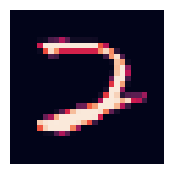

In [33]:
dataiter = iter(train_loader)
sample = next(dataiter)[0][0]
sample = sample.numpy().transpose(1, 2, 0)
plt.figure(figsize=(2, 2))
plt.imshow(sample)
plt.axis('off')
plt.show()

In [34]:
for _, (data, label) in enumerate(train_loader):
    print(label)

tensor([6, 6, 4, 4, 6, 3, 2, 9, 5, 0, 7, 9, 5, 3, 5, 1, 0, 9, 3, 2, 7, 1, 0, 7,
        3, 9, 3, 9, 7, 0, 3, 6])
tensor([8, 1, 5, 0, 2, 2, 3, 3, 1, 2, 3, 8, 6, 1, 9, 2, 4, 8, 4, 9, 6, 6, 9, 9,
        6, 7, 1, 6, 8, 2, 2, 5])
tensor([6, 1, 7, 2, 6, 5, 4, 5, 2, 3, 0, 2, 5, 2, 7, 4, 1, 9, 9, 6, 9, 3, 7, 8,
        1, 1, 6, 7, 0, 1, 4, 6])
tensor([7, 7, 1, 1])


In [35]:
tic = time.time()
early_epoch = 0
acc_list = [0.00]
path = './model/finetune_rmae.pt'

for epoch in range(100):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(classifier, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(classifier, test_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to finetune_rmae.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(classifier.state_dict(), path)
        early_epoch = 0
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]
        early_epoch += 1
        if early_epoch == 15:
            print('Early stopping, the most optimal valid_acc is: {:.2f}%'.format(acc_list[-1].item()))
            break
  
toc = time.time()
print("Training Time: {:.2f} seconds".format(toc-tic))
print("**************************************************")

Epoch: 001 - train_loss: 2.3034 - train_acc: 17.0000 - valid_loss: 2.1482 - valid_acc: 24.7500
val_acc improved from 0.0000 to 24.7500, saving model to finetune_rmae.pt
Epoch: 002 - train_loss: 2.0413 - train_acc: 36.0000 - valid_loss: 1.9987 - valid_acc: 43.2200
val_acc improved from 24.7500 to 43.2200, saving model to finetune_rmae.pt
Epoch: 003 - train_loss: 1.8555 - train_acc: 63.0000 - valid_loss: 1.8471 - valid_acc: 57.4200
val_acc improved from 43.2200 to 57.4200, saving model to finetune_rmae.pt
Epoch: 004 - train_loss: 1.6540 - train_acc: 70.0000 - valid_loss: 1.6774 - valid_acc: 64.1200
val_acc improved from 57.4200 to 64.1200, saving model to finetune_rmae.pt
Epoch: 005 - train_loss: 1.4295 - train_acc: 77.0000 - valid_loss: 1.4981 - valid_acc: 70.3700
val_acc improved from 64.1200 to 70.3700, saving model to finetune_rmae.pt
Epoch: 006 - train_loss: 1.2445 - train_acc: 82.0000 - valid_loss: 1.3244 - valid_acc: 75.1200
val_acc improved from 70.3700 to 75.1200, saving model t

In [36]:
path = './model/finetune_rmae.pt'

classifier.load_state_dict(torch.load(path))
classifier.eval()
print('done')

done


In [37]:
tar_test, pre_test = test(classifier, valid_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [38]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 96.12, AA: 96.12, Kappa: 0.9568
*******************************************************************
Recal: [98.56 96.72 96.5  97.03 96.47 96.9  97.83 93.83 90.61 96.73]
*******************************************************************
